In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [ ]:
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop

In [ ]:
train_dir = "/content/drive/My Drive/CSE400/Data Pre Processing 3/Train"
val_dir = "/content/drive/My Drive/CSE400/Data Pre Processing 3/Validation"
test_dir = "/content/drive/My Drive/CSE400/Data Pre Processing 3/Test"

In [ ]:
model = ResNet50(include_top=False,input_shape=(224, 224, 3), weights='imagenet')
input_shape = (224,224)

94773248/94765736 [==============================] - 2s 0us/step


In [ ]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  rotation_range=30,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.01,
                                  zoom_range=[0.9, 1.25],
                                  horizontal_flip=True,
                                  vertical_flip=False)

datagen_val = ImageDataGenerator(rescale=1./255)

datagen_test = ImageDataGenerator(rescale=1./255)

In [ ]:
batch_size = 16

generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,                                                 
                                                    shuffle=True)

generator_val = datagen_val.flow_from_directory(directory=val_dir,
                                                target_size=input_shape,
                                                batch_size=batch_size,
                                                shuffle=False)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 4468 images belonging to 2 classes.
Found 639 images belonging to 2 classes.
Found 655 images belonging to 2 classes.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

cls_train = generator_train.classes
cls_test = generator_test.classes


class_names = list(generator_train.class_indices.keys())
num_classes = generator_train.num_classes
num_classes

2

In [ ]:
def print_layer_trainable():
    for layer in model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))


print_layer_trainable()

True:	input_1
True:	conv1_pad
True:	conv1_conv
True:	conv1_bn
True:	conv1_relu
True:	pool1_pad
True:	pool1_pool
True:	conv2_block1_1_conv
True:	conv2_block1_1_bn
True:	conv2_block1_1_relu
True:	conv2_block1_2_conv
True:	conv2_block1_2_bn
True:	conv2_block1_2_relu
True:	conv2_block1_0_conv
True:	conv2_block1_3_conv
True:	conv2_block1_0_bn
True:	conv2_block1_3_bn
True:	conv2_block1_add
True:	conv2_block1_out
True:	conv2_block2_1_conv
True:	conv2_block2_1_bn
True:	conv2_block2_1_relu
True:	conv2_block2_2_conv
True:	conv2_block2_2_bn
True:	conv2_block2_2_relu
True:	conv2_block2_3_conv
True:	conv2_block2_3_bn
True:	conv2_block2_add
True:	conv2_block2_out
True:	conv2_block3_1_conv
True:	conv2_block3_1_bn
True:	conv2_block3_1_relu
True:	conv2_block3_2_conv
True:	conv2_block3_2_bn
True:	conv2_block3_2_relu
True:	conv2_block3_3_conv
True:	conv2_block3_3_bn
True:	conv2_block3_add
True:	conv2_block3_out
True:	conv3_block1_1_conv
True:	conv3_block1_1_bn
True:	conv3_block1_1_relu
True:	conv3_block1

**My codes stared**

**Visualizing Intermediate Representations**

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random cat or dog image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

**My Code ended**

In [ ]:
transfer_layer = model.get_layer('conv5_block3_out')
conv_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [ ]:
# Define a Callback class that stops training once accuracy reaches 99.9%
DESIRED_ACCURACY = 0.50
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc') is not None and logs.get('acc') >= DESIRED_ACCURACY):
      print("\nReached 90.0% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

**Inception er fully connected layer gula baad diye dichilam. So shobar last projonto jeta ache ota conv_model e save kore then amra nijera model create kore nibo**

In [ ]:
#for layer in conv_model.layers:
#    layer.trainable = False
    
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dropout(0.5))

new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
#new_model.add(Dense(512, activation='relu'))


# Add the final layer for the actual classification.
new_model.add(Dense(num_classes, activation='softmax'))


In [ ]:
optimizer = RMSprop(lr=0.0001)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
def print_layer_trainable():
    for layer in new_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))


print_layer_trainable()

True:	functional_1
True:	flatten
True:	dropout
True:	dense
True:	dense_1


In [ ]:
epochs = 10
# steps_per_epoch = 10
steps_per_epoch = generator_train.n / batch_size
steps_val = generator_val.n / batch_size
steps_test = generator_test.n / batch_size


history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test,
                                  callbacks=[callbacks])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
280/279 [==============================] - 2183s 8s/step - loss: 0.6099 - accuracy: 0.9203 - val_loss: 3.0847 - val_accuracy: 0.6504
Epoch 2/10
280/279 [==============================] - 143s 511ms/step - loss: 0.2883 - accuracy: 0.9635 - val_loss: 2.6919 - val_accuracy: 0.6534
Epoch 3/10
280/279 [==============================] - 143s 510ms/step - loss: 0.7107 - accuracy: 0.9700 - val_loss: 12.4053 - val_accuracy: 0.7115
Epoch 4/10
280/279 [==============================] - 142s 509ms/step - loss: 0.3756 - accuracy: 0.9725 - val_loss: 0.7179 - val_accuracy: 0.9206
Epoch 5/10
280/279 [==============================] - 143s 509ms/step - loss: 0.1460 - accuracy: 0.9801 - val_loss: 1.5831 - val_accuracy: 0.9145
Epoch 6/10
280/279 [==============================] - 142s 509ms/step - loss: 0.1200 - accuracy: 0.9799 - val_loss: 1.4258 - val_accuracy: 0.8840
Epoch 7/10
280/279 [=============================

In [ ]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Instructions for updating:
Please use Model.evaluate, which supports generators.
Test-set classification accuracy: 95.88%


In [ ]:
import cv2
import os
from tqdm import tqdm

In [ ]:
path = "/content/drive/My Drive/CSE400/Data Pre Processing 3/Test/Yes"

test_data = np.empty((1, 224, 224, 3))

for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
    try:
        img_array = cv2.imread(os.path.join(path,img))  # convert to array
        new_array = cv2.resize(img_array, (224, 224))  # resize to normalize data size
        
        #new_array = new_array.reshape((224, 224))
        
       
        new_array = new_array.reshape((-1, 224, 224, 3))
        #print(new_array.shape)
        test_data = np.append(test_data, new_array, axis = 0)  # add this to our training_data
    except Exception as e:  # in the interest in keeping the output clean...
        print(e)
        pass
        #except OSError as e:
        #    print("OSErrroBad img most likely", e, os.path.join(path,img))
        #except Exception as e:
        #    print("general exception", e, os.path.join(path,img))

100%|██████████| 229/229 [00:06<00:00, 32.95it/s]


In [ ]:
test_data.shape

(230, 224, 224, 3)

In [ ]:
scaled_data = test_data/255
new_model.predict_classes(scaled_data)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
path = "/content/drive/My Drive/CSE400/Data Pre Processing 3/Test/No"

test_data_2 = np.empty((1, 224, 224, 3))

for img_2 in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
    try:
        img_array_2 = cv2.imread(os.path.join(path,img_2))  # convert to array
        new_array_2 = cv2.resize(img_array_2, (224, 224))  # resize to normalize data size
        
        #new_array_2 = new_array.reshape((224, 224))
        
       
        new_array_2 = new_array_2.reshape((-1, 224, 224, 3))
        #print(new_array_2.shape)
        test_data_2 = np.append(test_data_2, new_array_2, axis = 0)  # add this to our training_data
    except Exception as e:  # in the interest in keeping the output clean...
        print(e)
        pass
        #except OSError as e:
        #    print("OSErrroBad img most likely", e, os.path.join(path,img))
        #except Exception as e:
        #    print("general exception", e, os.path.join(path,img))

100%|██████████| 426/426 [00:20<00:00, 21.24it/s]


In [ ]:
test_data_2.shape

(427, 224, 224, 3)

In [ ]:
scaled_data_2 = test_data_2/255
new_model.predict_classes(scaled_data_2)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
#new_model.save('/content/drive/My Drive/CSE400/Saving Model/ResNet')

<Figure size 432x288 with 0 Axes>

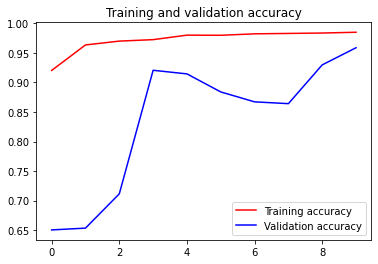

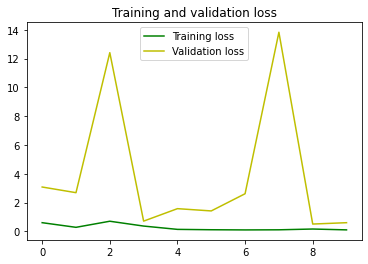

<Figure size 432x288 with 0 Axes>

In [ ]:


#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[   'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------


plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------


plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()